1. Installing Dependencies


In [1]:
# %pip install tensorflow==2.6 opencv-python mediapipe==0.9.1.0 scikit-learn matplotlib

In [2]:
import os
import torch
visible_devices = os.environ.get("CUDA_VISIBLE_DEVICES")
print(f"CUDA_VISIBLE_DEVICES: {visible_devices}")
print(torch.cuda.is_available())

CUDA_VISIBLE_DEVICES: None
True


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import mediapipe as mp

2. Capturing video and Drawing keypoints using MP Holistic

In [3]:
# Keypoints Portion
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
   #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

3. Extract Keypoint Values

In [8]:
#Extracting Keypoints into a numpy array
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4) 
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) # single row of data for each image

4. Setup Folders for Collection

In [13]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data_Zoomed') 

# Actions that we try to detect
actions = np.array(['ako',  'bakit', 'F', 'hi', 'hindi', 'ikaw',  'kamusta', 'L', 'maganda', 'magandang umaga', 'N', 'O', 'oo', 'P', 'salamat'])

# number of videos we want to use for training
no_sequences = 41

# Videos are going to be 30 frames in length
sequence_length = 30

In [14]:
# Define input directories
# input_dir = '../videos/extra_zoomed_videos'

for action in actions: 
    # filename_action = os.path.join(input_dir, action)
    # no_sequences = the number of files in filename_action
    # no_sequences = len([name for name in os.listdir(filename_action) if os.path.isfile(os.path.join(filename_action, name))])
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

5. Collect Keypoint Values for Training and Testing

In [15]:
# Set up Mediapipe Holistic model
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

input_dir = '../videos/zoomed_videos/'

# Loop through actions
for action in actions:
    # Loop through sequences
    filename_action = os.path.join(input_dir, action)
    # no_sequences = the number of files in filename_action
    # no_sequences = len([name for name in os.listdir(filename_action) if os.path.isfile(os.path.join(filename_action, name))])
    for sequence in range(no_sequences):       
        filename = os.path.join(input_dir, action, '{}.mp4'.format(sequence))
        cap = cv2.VideoCapture(filename) # Open video file
        # Loop through sequence length
        for frame_num in range(sequence_length):
            # Loop through video frames
            # Read video frame
            ret, frame = cap.read()

            if not ret:
                # End of video
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_landmarks(image, results)
                
            # NEW Export keypoints
            keypoints = extract_keypoints(results)
            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
            np.save(npy_path, keypoints)
                
        # Release video file
        cap.release()
cv2.destroyAllWindows()

[ WARN:0@1478.516] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@1478.516] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin1231 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@1478.517] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@1478.517] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/module

In [12]:
# Set up Mediapipe Holistic model
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

input_dir = '../videos/flipped_videos/'

# Loop through actions
for action in actions:
    # Loop through sequences
    filename_action = os.path.join(input_dir, action)
    # no_sequences = the number of files in filename_action
    # no_sequences = len([name for name in os.listdir(filename_action) if os.path.isfile(os.path.join(filename_action, name))])
    for sequence in range(no_sequences):       
        filename = os.path.join(input_dir, action, '{}.mp4'.format(sequence))
        cap = cv2.VideoCapture(filename) # Open video file
        # Loop through sequence length
        for frame_num in range(sequence_length):
            # Loop through video frames
            # Read video frame
            ret, frame = cap.read()

            if not ret:
                # End of video
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_landmarks(image, results)
                
            # NEW Export keypoints
            keypoints = extract_keypoints(results)
            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
            np.save(npy_path, keypoints)
                
        # Release video file
        cap.release()
cv2.destroyAllWindows()

[ WARN:0@857.345] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@857.345] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin616 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@857.345] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@857.346] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/vid

In [ ]:
cap.release()
cv2.destroyAllWindows()

6. Preprocess Data and Create Labels and Features

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

{'ako': 0, 'bakit': 1, 'F': 2, 'hi': 3, 'hindi': 4, 'ikaw': 5, 'kamusta': 6, 'L': 7, 'maganda': 8, 'magandang umaga': 9, 'N': 10, 'O': 11, 'oo': 12, 'P': 13, 'salamat': 14}


In [8]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
X = np.array(sequences)
print(np.array(sequences).shape)
print(np.array(labels).shape)

(1125, 30, 1662)
(1125,)


In [10]:
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_test.shape

(113, 15)

7. Build and Train LSTM Neural Network

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import Conv1D

In [12]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [13]:
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=1200, callbacks=[tb_callback])

Epoch 1/1200
32/32 [==============================] - 7s 70ms/step - loss: 2.7198 - categorical_accuracy: 0.0672
Epoch 2/1200
32/32 [==============================] - 2s 65ms/step - loss: 2.7003 - categorical_accuracy: 0.0623
Epoch 3/1200
32/32 [==============================] - 3s 81ms/step - loss: 2.7095 - categorical_accuracy: 0.0692
Epoch 4/1200
32/32 [==============================] - 2s 69ms/step - loss: 2.7338 - categorical_accuracy: 0.0731
Epoch 5/1200
32/32 [==============================] - 2s 72ms/step - loss: 2.7081 - categorical_accuracy: 0.0781
Epoch 6/1200
32/32 [==============================] - 2s 67ms/step - loss: 2.7073 - categorical_accuracy: 0.0721
Epoch 7/1200
32/32 [==============================] - 2s 65ms/step - loss: 2.6961 - categorical_accuracy: 0.0998
Epoch 8/1200
32/32 [==============================] - 2s 64ms/step - loss: 2.6502 - categorical_accuracy: 0.1176
Epoch 9/1200
32/32 [==============================] - 2s 63ms/step - loss: 2.5833 - categorical_

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            319168    
                                                                 
 lstm (LSTM)                 (None, 28, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 28, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 15)                4

8. Make Predictions


In [27]:
res = model.predict(X_test)
actions[np.argmax(res[2])]

4/4 [==============================] - 0s 20ms/step


'hindi'

In [29]:
actions[np.argmax(y_test[2])]

'oo'

9. Save Weights


In [18]:
model.save('Test1.0')

INFO:tensorflow:Assets written to: Test1.0\assets


In [ ]:
del model
model.load_weights('action.h5')

10. Evaluation using Confusion Matrix and Accuracy

In [19]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [20]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 32ms/step


In [21]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [22]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]],

       [[3, 0],
        [0, 2]]], dtype=int64)

In [23]:
accuracy_score(ytrue, yhat)

1.0

11. Test in Real Time

In [24]:
from scipy import stats

In [25]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

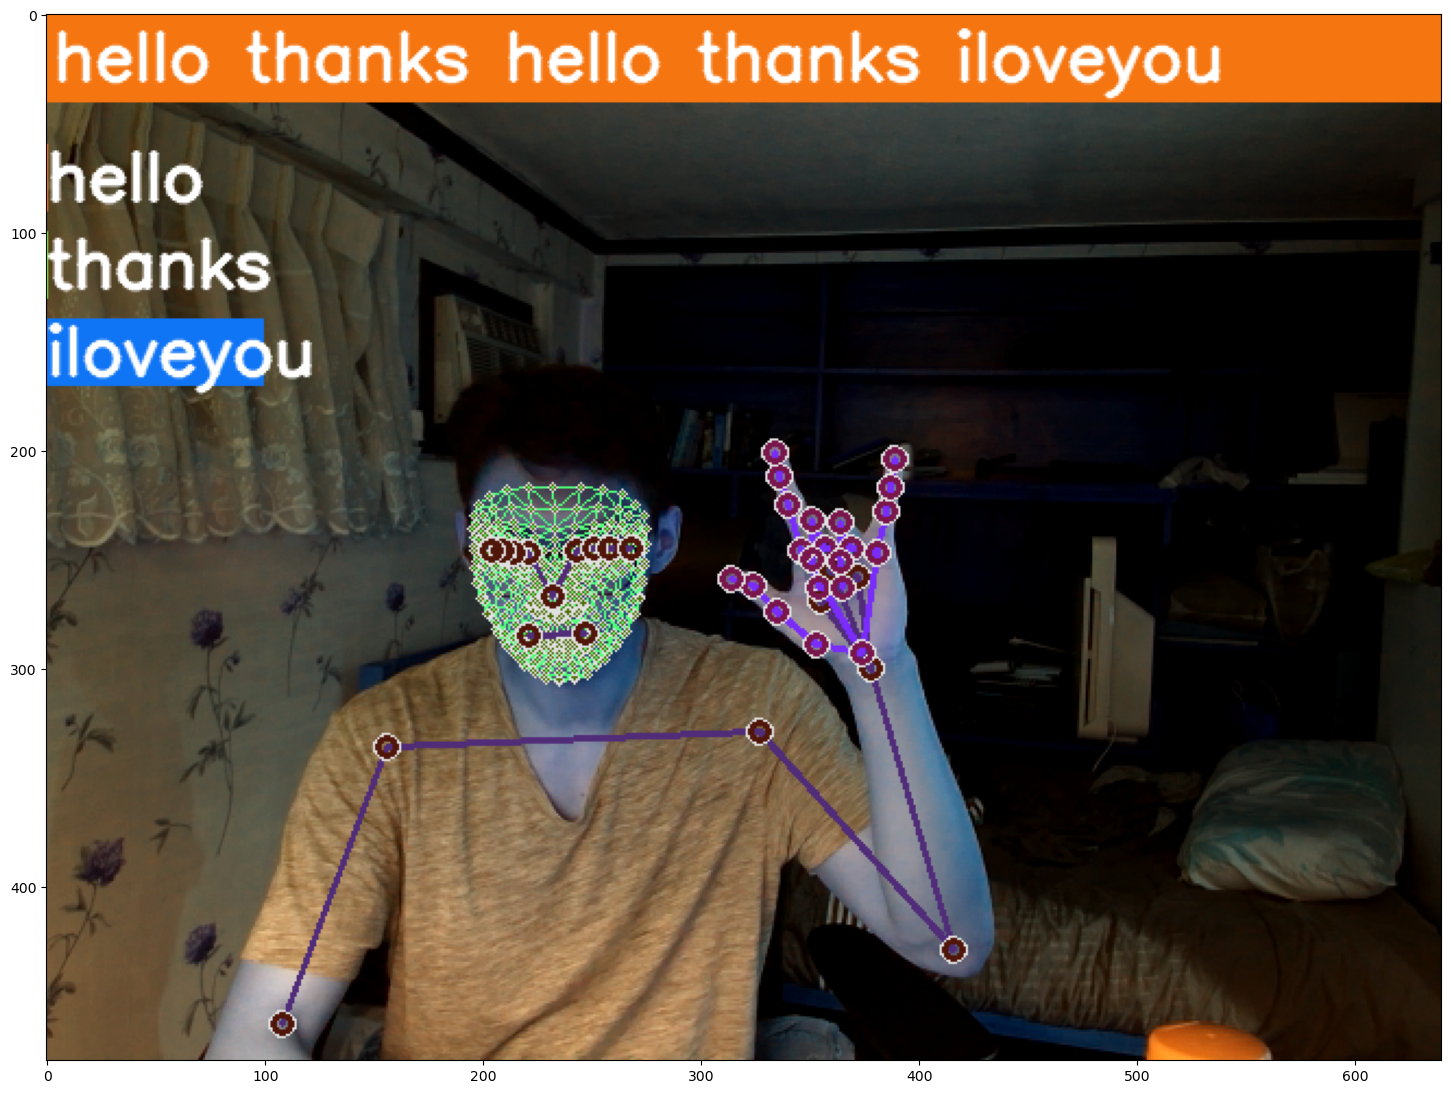

In [27]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [26]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti